In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
#########################################
### Generate data from Burgers system ###
#########################################
### du/dt = 0.01 * d^2u/dx^2 - u * du/dx ###
### u(x, 0) = -sin(pi * x) ###
### u(0, t) = u(1, t) = 0 ###


# N_ic = 100  # Number of initial condition points
# N_bc = 50   # Number of boundary condition points
# N_f = 10000

N_ic = 100 # Number of initial condition points
N_bc = 50 # Number of boundary condition points (on each boundary)
N_f = 10000 # Number of collocation points

 # Initial condition: u(0, x) = -sin(pi * x)
x_ic = torch.linspace(-1, 1, N_ic).reshape(-1, 1)
t_ic = torch.zeros_like(x_ic)
z_ic = torch.cat([t_ic, x_ic], dim=1)
u_ic = -torch.sin(torch.pi * x_ic)

# Boundary conditions: u(t, -1) = 0 and u(t, 1) = 0
t_bc = torch.linspace(0, 1, 2*N_bc).reshape(-1, 1)
x_bc = torch.cat([-torch.ones(N_bc), torch.ones(N_bc)], dim=0).reshape(-1, 1)
z_bc = torch.cat([t_bc, x_bc], dim=1)
u_bc = torch.zeros_like(x_bc)

# Combine the initial and boundary conditions
boundary_points = torch.cat([z_ic, z_bc], dim=0)
boundary_values = torch.cat([u_ic, u_bc], dim=0)

# Collocation points for PDE
# x_f = torch.rand(N_f, 1, requires_grad=True)*2 - 1    # Random points in [-1, 1]
# t_f = torch.rand(N_f, 1, requires_grad=True)          # Random points in [0, 1]

# Collocation points for PDE randomly generated
x_f = torch.rand(N_f, 1, requires_grad=True)*2 - 1    # Random points in [-1, 1]
t_f = torch.rand(N_f, 1, requires_grad=True)          # Random points in [0, 1]
z_f = torch.cat([t_f, x_f], dim=1)

In [3]:
# Set up the neural network
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(2, 50)
        self.fc2 = torch.nn.Linear(50, 50)
        self.fc3 = torch.nn.Linear(50, 50)
        self.fc4 = torch.nn.Linear(50, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)

        return x
    
# Initialize the neural network
model = Net()

# Set up the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop for PINN burgers equation

N = 100000
D = 10000

epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    u_pred = model(z_f)
    u_t = torch.autograd.grad(u_pred, t_f, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_x = torch.autograd.grad(u_pred, x_f, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_f, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    f = u_t - (0.01/torch.pi) * u_xx + u_pred * u_x
    loss = torch.mean(f**2) + torch.mean((model(boundary_points) - boundary_values)**2)
    loss.backward(retain_graph=True)
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

    if (epoch+1) % 6000 == 0:
        x = torch.rand(N, 1, requires_grad=True) * 2 - 1  # Random points in [-1, 1]
        t = torch.rand(N, 1, requires_grad=True)
        z = torch.cat([t, x], dim=1)

        # Compute residuals
        u = model(z)
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        f = u_t - (0.01 / torch.pi) * u_xx + u * u_x

        res = f**2

        # Update z_f with highest residual points
        idx = torch.topk(res.squeeze(), D, largest=True, dim=0).indices
        t_f = t[idx].detach().clone().requires_grad_(True)
        x_f = x[idx].detach().clone().requires_grad_(True)
        z_f = torch.cat([t_f, x_f], dim=1)

Epoch 1/10000, Loss: 0.23919261991977692


KeyboardInterrupt: 

C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


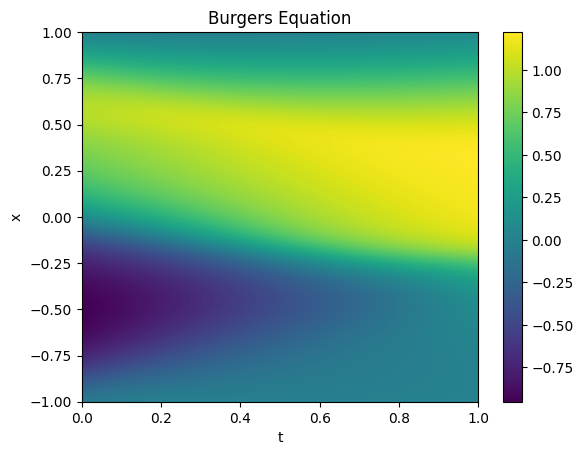

In [5]:
# Plot the results as an image on a meshgrid
x = torch.linspace(-1, 1, 1000)
t = torch.linspace(0, 1, 1000)
X, T = torch.meshgrid(x, t)
Z = torch.cat([T.reshape(-1, 1), X.reshape(-1, 1)], dim=1)
U = model(Z).reshape(1000, 1000).detach().numpy()
plt.imshow(U, extent=[0, 1, -1, 1], aspect='auto')
plt.colorbar()
plt.xlabel('t')
plt.ylabel('x')
plt.title('Burgers Equation')
plt.show()

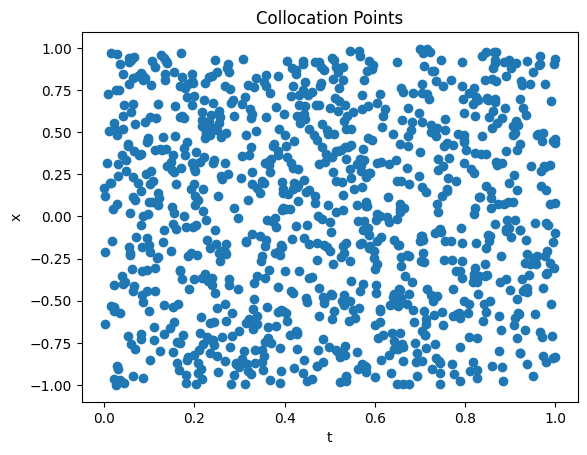

In [6]:
N_f = 1000

x_f = torch.rand(N_f, 1, requires_grad=True)*2 - 1    # Random points in [-1, 1]
t_f = torch.rand(N_f, 1, requires_grad=True)          # Random points in [0, 1]

# Plot the points in a scatter plot
plt.scatter(t_f.detach().numpy(), x_f.detach().numpy())
plt.xlabel('t')
plt.ylabel('x')
plt.title('Collocation Points')
plt.show()

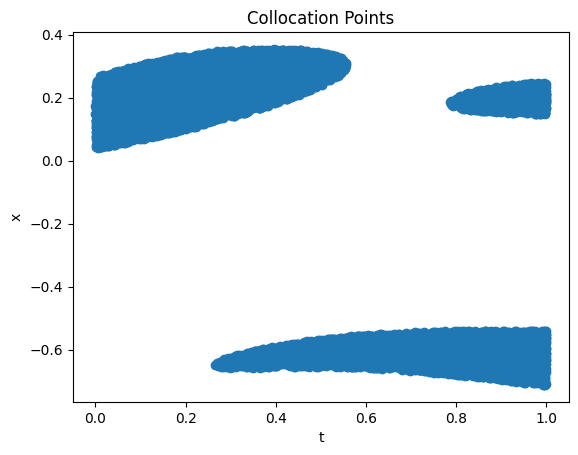

In [ ]:
# Plot the points in a scatter plot
plt.scatter(z_f[:, 0].detach().numpy(), z_f[:, 1].detach().numpy())
plt.xlabel('t')
plt.ylabel('x')
plt.title('Collocation Points')
plt.show()